In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
import os
from sklearn.preprocessing import StandardScaler

In [34]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')
files = os.listdir(datasets_dir)
for file in files:
    if file.endswith('.csv'):  
        file_path = os.path.join(datasets_dir, file)
        df = pd.read_csv(file_path)
        print(f"Data from {file}:")
        print(df.head()) 

Data from UNH_2006-01-01_to_2018-01-01.csv:
         Date   Open   High    Low  Close   Volume Name
0  2006-01-03  62.60  62.60  60.60  61.73  8070600  UNH
1  2006-01-04  61.89  62.20  61.60  61.88  5587100  UNH
2  2006-01-05  62.23  62.88  61.49  61.69  5626000  UNH
3  2006-01-06  62.75  62.93  62.03  62.90  5577800  UNH
4  2006-01-09  62.90  62.90  61.26  61.40  8831000  UNH
Data from GE_2006-01-01_to_2018-01-01.csv:
         Date   Open   High    Low  Close    Volume Name
0  2006-01-03  35.10  35.40  34.80  35.37  33221400   GE
1  2006-01-04  35.35  35.40  35.10  35.32  24017300   GE
2  2006-01-05  35.27  35.35  35.10  35.23  18860400   GE
3  2006-01-06  35.38  35.53  35.19  35.47  22085300   GE
4  2006-01-09  35.40  35.43  35.24  35.38  20716900   GE
Data from TRV_2006-01-01_to_2018-01-01.csv:
         Date   Open   High    Low  Close   Volume Name
0  2006-01-03  44.85  46.00  44.52  45.99  3843800  TRV
1  2006-01-04  45.99  46.61  45.85  46.50  2285900  TRV
2  2006-01-05  46.79  4

In [35]:
datasets_dir = os.path.join(os.getcwd(), 'datasets')

file_name = 'JPM_2006-01-01_to_2018-01-01.csv'  # Replace with your file name

# Construct the full path to the file
file_path = os.path.join(datasets_dir, file_name)

# Read the file using pandas
df = pd.read_csv(file_path)

# Display the data
print(f"Data from {file_name}:")
print(df.head())  # Print the first few rows of the DataFrame

Data from JPM_2006-01-01_to_2018-01-01.csv:
         Date   Open   High    Low  Close    Volume Name
0  2006-01-03  39.83  40.36  39.30  40.19  12839400  JPM
1  2006-01-04  39.78  40.14  39.42  39.62  13491800  JPM
2  2006-01-05  39.61  39.81  39.50  39.74   8109400  JPM
3  2006-01-06  39.92  40.24  39.55  40.02   7966900  JPM
4  2006-01-09  39.88  40.72  39.88  40.67  16575200  JPM


In [36]:
df['High']

0        40.36
1        40.14
2        39.81
3        40.24
4        40.72
         ...  
3015    108.46
3016    107.99
3017    107.29
3018    107.84
3019    108.28
Name: High, Length: 3020, dtype: float64

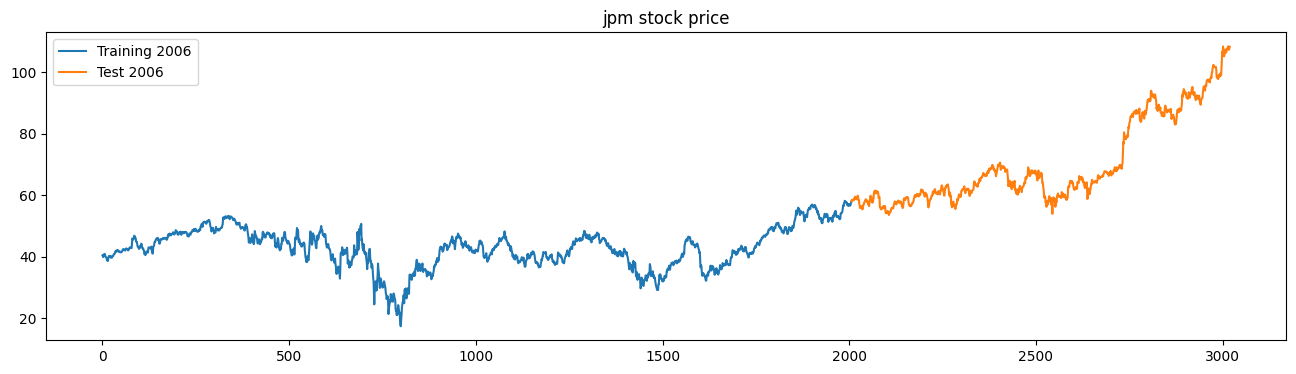

In [37]:
df['High'].loc[:'2006'].plot(figsize=(16,4),)
df['High'].loc['2006':].plot(figsize=(16,4),)
plt.legend(['Training 2006', 'Test 2006'])
plt.title('jpm stock price')
plt.show()

In [38]:
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

In [39]:
train_data= df[:'2006']['High'].values
test_data= df['2006':]['High'].values

In [40]:
train_data.shape

(251,)

In [41]:
size = 60

In [42]:
def split(dataset , size):
    X=[]
    y=[]

    for i in range(len(dataset)-size):
        X.append(dataset[i:i + size])
        y.append(dataset[i+ size])
    return X,y

In [43]:
X_train, y_train= split(train_data, 60)
X_test, y_test= split(test_data, 60)

In [44]:
X_train[0]

array([40.36, 40.14, 39.81, 40.24, 40.72, 40.75, 40.87, 40.42, 40.03,
       39.82, 39.71, 39.47, 38.82, 38.7 , 38.53, 38.68, 39.81, 40.04,
       39.97, 40.19, 40.22, 40.16, 40.1 , 39.6 , 39.6 , 39.62, 40.03,
       39.98, 40.31, 40.33, 40.5 , 40.82, 40.82, 40.95, 41.55, 41.57,
       41.83, 41.95, 41.6 , 41.94, 41.84, 42.09, 41.81, 41.66, 41.74,
       41.74, 41.4 , 41.48, 41.5 , 41.34, 41.53, 41.5 , 41.55, 41.71,
       42.2 , 42.2 , 42.43, 42.2 , 42.21, 42.08])

In [45]:
scalerX = StandardScaler()
scalery= StandardScaler()

X_train = scalerX.fit_transform(X_train)
X_test= scalerX.transform(X_test)

y_train= scalery.fit_transform(np.array(y_train).reshape(-1,1)).flatten()
y_test= scalery.transform(np.array(y_test).reshape(-1,1)).flatten()

In [46]:
X_train[0]
y_test[:5]

array([-1.41032435, -1.45306349, -1.23081998, -1.23081998, -1.14534171])

In [47]:
n_features = 1
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1],n_features)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1],n_features)

In [48]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class LSTMModel(nn.Module):
    def __init__(self, size, n_features):
        super(LSTMModel, self).__init__()
        
        self.lstm1 = nn.LSTM(input_size=n_features, hidden_size=10, batch_first=True)
        
        self.lstm2 = nn.LSTM(input_size=10, hidden_size=10, batch_first=True)
        
        self.fc1 = nn.Linear(10, 5)
        
        self.fc2 = nn.Linear(5, 1)

    def forward(self, x):
        x, _ = self.lstm1(x)
        
        x, _ = self.lstm2(x)
        
        x = x[:, -1, :]
        
        x = F.relu(self.fc1(x))
        
        x = self.fc2(x)
        
        return x
number_of_steps = 60  # As per your data
n_features = 1  # The feature size, assuming 1 feature (e.g., 'High' column from your data)
model = LSTMModel(size, n_features)
summary(model, input_size=(size, n_features))


RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [LSTM: 1, LSTM: 1]

In [124]:
model = LSTMModel(size, n_features)

In [126]:
summary(model, input_size=(60, 1))

AttributeError: 'tuple' object has no attribute 'size'